In [174]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

In [175]:
# dodac produkcje zwracaja nowe pod grafy <check> 
# dodac do node'ow typu I id parenta, pierwszy node Typu I bedzie zawierac parenta -1 <check>
# layer ma byc lista <check>
# wizualizacja warstwy (brutem) <check>
# dodac check czy mozna wywolac <check>
#czyscic kernel i out przed pushem

In [176]:
class Id_creator:
    def __init__(self):
        self.last_id = -1
    def get_id(self):
        self.last_id +=1
        return self.last_id
    def __call__(self):
        return self.get_id()
    
    
class CannotExecuteProduction(Exception):
        pass
    
    
class Graph_layers:
    def __init__(self):
        self._node_id_gen =  Id_creator()
        G = nx.Graph()
        G.add_nodes_from([(self._node_id_gen(), {'pos': (0,0),'type': 'e'})])
        self._layers=[[G]]
        
    def get_layer(self, i):
        return self._layers[i]
    
    def add_to_layer(self,i,G):
        return self._layers[i].append(G)
    
    def add_to_last_layer(self,G):
        return self._layers[-1].append(G)
        
    def add_new_layer(self, G_new):
        self._layers.append([G_new])            
        
    def get_last_layer_index(self):
        return len(self._layers) - 1
    
    def get_last_layer(self,i):
        return self._layers[i]
    
    def display_i_layer(self, i):
        G_layer = self._layers[i]
        G = self._layers[i][0] if  len(self._layers[i])==1 else reduce(nx.algorithms.operators.binary.compose,G_layer)
        
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx(G, pos)
        
    def get_node_id_gen(self):
        return self._node_id_gen

In [177]:
def p1(G, base_node_id, n_id_gen, side_len=2, max_random_offset = 0):
    assert(G.nodes[base_node_id]['type'].lower() == 'e' )
    assert(len(G.nodes)==1)
    all_new_nodes = []
    all_new_edges = []
    base_pos = G.nodes[base_node_id]['pos']
    x_offset = ((np.random.random()-0.5) * max_random_offset * 2)
    y_offset = ((np.random.random()-0.5) * max_random_offset * 2)
    i_node_x, i_node_y = base_pos[0], base_pos[1]
    i_node = (n_id_gen(), {'pos': (i_node_x+x_offset, i_node_y-y_offset), 'type': 'I','parent': -1})
    all_new_nodes.append(i_node)
    
    half_side_len = side_len/2
    e_nodes = [
        (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y + half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y + half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x + half_side_len, i_node_y - half_side_len),'type': 'e'}),
        (n_id_gen(), {'pos': (i_node_x - half_side_len, i_node_y - half_side_len),'type': 'e'})
    ]
    for i in range(len(e_nodes)):
        all_new_edges.extend([(e_nodes[i][0],e_nodes[i+1 if i + 1 < len(e_nodes) else 0][0])])
        all_new_edges.extend([(i_node[0],e_nodes[i][0])])
    
    all_new_nodes.extend(e_nodes)
    nG = nx.Graph()
    nG.add_nodes_from(all_new_nodes)
    nG.add_edges_from(all_new_edges)
    return nG, i_node


In [178]:
def conc_duplicates(G):
    org_nodes = list(G.nodes(data=True))

    org_nodes_dict = {}
    for node_id,data in org_nodes:
        try:
            org_nodes_dict[data['pos']].append(node_id)
        except KeyError:
            org_nodes_dict[data['pos']]=[node_id]

    nodes_to_replace = {} #keys nodes to be deleted, values nodes to replace them
    for key,ids in org_nodes_dict.items():
        if len(ids) > 1:
            for id_ in ids[1:]:
                nodes_to_replace[id_] = ids[0]
                
    for old_node, new_node in nodes_to_replace.items():
        neighbors = list(G.neighbors(old_node))
        for n in neighbors:
            G.remove_edge(old_node,n)
            G.add_edge(new_node,n)
        G.remove_node(old_node)
    return G

In [179]:
def avg_pos(pos1, pos2):
    return ((pos1[0] + pos2[0])/2, (pos1[1] + pos2[1])/2)

def rm_edge_if_exists(G,n1id,n2id):
    try:
        G.remove_edge(n1id,n2id)
    except nx.NetworkXError:
        pass
    


#     e0 - - - e1
#      | \    / |
#      |  I0    |
#      | /   \  |
#     e2 - - - e3
#
#          |
#         \/
#
#     e0 - - - n0 - - - e1
#     | \    / | \    / |
#     |  I1    |  I2    |
#     | /   \  | /   \  |
#    n1 - - - n2 - - - n3
#     | \    / | \    / |
#     |  I3    |  I4    |
#     | /   \  | /   \  |
#    e2 - - - n4 - - - e3

def p2(G, base_node_id, n_id_gen):
    assert(G.nodes[base_node_id]['type'].lower() == 'i')
    nG = nx.Graph()
    es = list(G.neighbors(base_node_id))
    if len(es) != 4:
        raise CannotExecuteProduction
    e0, e1, e2, e3 = None, None, None, None
    baseX, baseY = G.nodes[base_node_id]['pos']
    for ex in es:
        x,y = G.nodes[ex]['pos']
        if x<baseX:
            if y<baseY:
                e2= (ex,G.nodes[ex])
            if y>baseY:
                e0= (ex,G.nodes[ex])
        else:
            if y<baseY:
                e3= (ex,G.nodes[ex])
            if y>baseY:
                e1= (ex,G.nodes[ex])
    if not(G.has_edge(e0[0],e1[0]) and\
            G.has_edge(e1[0],e3[0]) and\
            G.has_edge(e3[0],e2[0]) and\
            G.has_edge(e0[0],e2[0]) and\
            G.has_edge(e0[0],base_node_id) and\
            G.has_edge(e1[0],base_node_id) and\
            G.has_edge(e2[0],base_node_id) and\
            G.has_edge(e3[0],base_node_id)\
            ):
        raise CannotExecuteProduction
    #prepare all new verticies accord to map above
    e0 = (n_id_gen(),{'pos': e0[1]['pos'],'type' : e0[1]['type']})
    e1 = (n_id_gen(),{'pos': e1[1]['pos'],'type' : e1[1]['type']})
    e2 = (n_id_gen(),{'pos': e2[1]['pos'],'type' : e2[1]['type']})
    e3 = (n_id_gen(),{'pos': e3[1]['pos'],'type' : e3[1]['type']})

    n0 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e1[1]['pos']),'type':'e'})
    n1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],e2[1]['pos']),'type':'e'})
    n2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e2[1]['pos']),'type':'e'})
    n3 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],e3[1]['pos']),'type':'e'})
    n4 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],e3[1]['pos']),'type':'e'})
    
    I1 = (n_id_gen(),{'pos' : avg_pos(e0[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I2 = (n_id_gen(),{'pos' : avg_pos(e1[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I3 = (n_id_gen(),{'pos' : avg_pos(e2[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    I4 = (n_id_gen(),{'pos' : avg_pos(e3[1]['pos'],n2[1]['pos']),'type':'I','parent':base_node_id})
    # add all new edges
    new_edges = [
        (e0[0],n0[0]),(n0[0],e1[0]),
        (e0[0],I1[0]),(n0[0],I1[0]), (n0[0],I2[0]),(e1[0],I2[0]),
        (e0[0],n1[0]),(n0[0],n2[0]),(e1[0],n3[0]),
        (n1[0],I1[0]),(n2[0],I1[0]), (n2[0],I2[0]),(n3[0],I2[0]),
        (n1[0],n2[0]),(n2[0],n3[0]),
        (n1[0],I3[0]),(n2[0],I3[0]), (n2[0],I4[0]),(n3[0],I4[0]),
        (n1[0],e2[0]),(n2[0],n4[0]),(n3[0],e3[0]),
        (e2[0],I3[0]),(n4[0],I3[0]), (n4[0],I4[0]),(e3[0],I4[0]),
        (e2[0],n4[0]),(n4[0],e3[0]),
    ]
    nG.add_nodes_from([e0,e1,e2,e3,n0,n1,n2,n3,n4,I1,I2,I3,I4])
    nG.add_edges_from(new_edges)
    return nG
#     conc_duplicates(G)

In [180]:
def p7(top_layer, lower_layer, node_ids, n_id_gen):
    return lower_layer

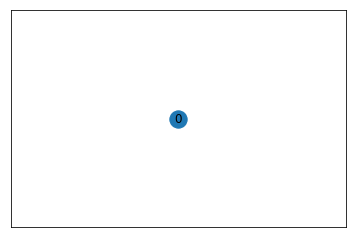

In [181]:
graph_layers = Graph_layers()
graph_layers.display_i_layer(0)

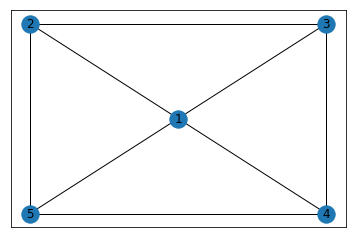

In [182]:
base_node = list(graph_layers.get_layer(0)[0].nodes(data=True))[0]
#indexing from 0 
first_layer_G = graph_layers.get_layer(0)[0].copy()

#apply p1 production
G, i_node = p1(first_layer_G, base_node[0], graph_layers.get_node_id_gen()) 
graph_layers.add_new_layer(G)

graph_layers.display_i_layer(1)

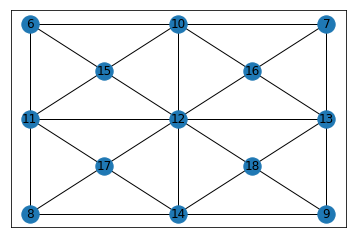

In [183]:
#apply p2 production
G = graph_layers.get_layer(1)[0]
nG = p2(G, 1, graph_layers.get_node_id_gen())
graph_layers.add_new_layer(nG)
graph_layers._layers[2][0].nodes(data=True)
graph_layers.display_i_layer(2)

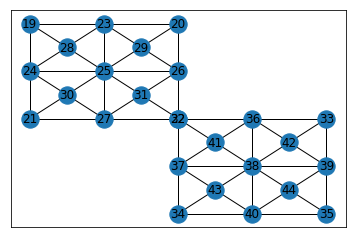

In [184]:
#apply p2 production 4 times
G = graph_layers.get_layer(2)[0]
graph_layers.add_new_layer( p2(G, 15, graph_layers.get_node_id_gen()))
graph_layers.add_to_last_layer(p2(G, 18, graph_layers.get_node_id_gen()))
graph_layers.display_i_layer(3)

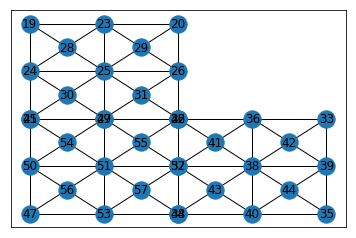

In [185]:
#apply p2 production
G = graph_layers.get_layer(2)[0]
graph_layers.add_to_last_layer(p2(G, 17, graph_layers.get_node_id_gen()))
graph_layers.display_i_layer(3)

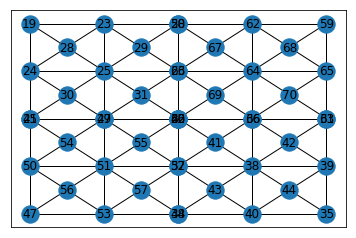

In [186]:
#apply p2 production
G = graph_layers.get_layer(2)[0]
graph_layers.add_to_last_layer(p2(G, 16, graph_layers.get_node_id_gen()))
graph_layers.display_i_layer(3)

In [187]:
    #
    #      I1  - e1    e1 - I3
    #        \\  /        \\ /
    #         e2          e2
    #        / \\         / \\
    #     I2  - e3     e3 - I4
    #
    #              |
    #             \\/
    #
    #      I1  - e1 - I3
    #        \\   |   /
    #            e2
    #        /   |   \\
    #     I2  - e3 - I4

test_p7_correct (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.034s

OK


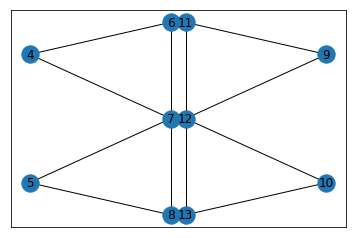

In [192]:
import unittest

class TestNotebook(unittest.TestCase):

    def create_valid_output_layer(self):
        graph_layers = Graph_layers()
        id_gen = graph_layers.get_node_id_gen()
        l2 = nx.Graph()
        l2_edges = []
        l2_nodes = []
        center_x, center_y, offset, = 2, 2, -1
        upper_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I'})
        lower_i_left = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I'})
        offset = -offset
        upper_i_right = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I'})
        lower_i_right = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I'})

        l2_nodes.extend([upper_i_right, upper_i_left, lower_i_left, lower_i_right])

        upper_e = (id_gen.get_id(), {'pos': (center_x, center_y + 1.5),'type': 'e'})
        mid_e = (id_gen.get_id(), {'pos': (center_x, center_y),'type': 'e'})
        lower_e = (id_gen.get_id(), {'pos': (center_x, center_y - 1.5),'type': 'e'})

        l2_nodes.extend([upper_e, mid_e, lower_e])
        l2_edges.extend([(upper_e[0], mid_e[0]), (lower_e[0], mid_e[0]),
                         (lower_e[0], lower_i_left[0]),
                         (lower_e[0], lower_i_right[0]),
                         (lower_i_left[0], mid_e[0]),
                         (lower_i_right[0], mid_e[0]),
                         (upper_i_left[0], mid_e[0]),
                         (upper_i_right[0], mid_e[0]),
                         (upper_i_right[0], upper_e[0]),
                         (upper_i_left[0], upper_e[0])])

        l2.add_nodes_from(l2_nodes)
        l2.add_edges_from(l2_edges)
        graph_layers.add_new_layer(l2)
        # graph_layers.display_i_layer(1)
        return graph_layers.get_layer(1)[0]


    def create_leaf_edges(self, parent, id_gen, offset, tiny_offset):
        center_x, center_y = 2, 2
        l2 = nx.Graph()
        l2_edges = []
        l2_nodes = []
        upper_i = (id_gen.get_id(), {'pos': (center_x + offset, center_y + 1),'type': 'I', 'parent': parent[0]})
        lower_i = (id_gen.get_id(), {'pos': (center_x + offset, center_y - 1),'type': 'I', 'parent': parent[0]})
        l2_nodes.extend([upper_i, lower_i])

        upper_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y + 1.5),'type': 'e'})
        mid_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y),'type': 'e'})
        lower_e = (id_gen.get_id(), {'pos': (center_x + tiny_offset, center_y - 1.5),'type': 'e'})

        l2_nodes.extend([upper_e, mid_e, lower_e])
        l2_edges.extend([(upper_e[0], mid_e[0]), (lower_e[0], mid_e[0]), (lower_e[0], lower_i[0]),
                         (lower_i[0], mid_e[0]),
                         (upper_i[0], mid_e[0]),
                         (upper_i[0], upper_e[0])])

        l2.add_nodes_from(l2_nodes)
        l2.add_edges_from(l2_edges)
        return l2, [lower_i[0], upper_i[0]]

    def create_valid_input_net(self):
        graph_layers = Graph_layers()
        side_len=2
        parent_node_x, parent_node_y = 1, 1
        id_gen = graph_layers.get_node_id_gen()
        parent_node = (id_gen.get_id(), {'pos': (parent_node_x, parent_node_y), 'type': 'E','parent': -1})

        half_side_len = side_len/2
        i_nodes = [
            (id_gen.get_id(), {'pos': (parent_node_x + half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]}),
            (id_gen.get_id(), {'pos': (parent_node_x - half_side_len, parent_node_y - half_side_len),'type': 'I', 'parent': parent_node[0]})
        ]
        l1_edges = []
        for i_node in i_nodes:
             l1_edges.extend([(i_node[0],parent_node[0])])

        l1 = nx.Graph()
        l1.add_nodes_from([parent_node])
        l1.add_nodes_from(i_nodes)
        l1.add_edges_from(l1_edges)
        graph_layers.add_new_layer(l1)

        center_x, center_y, offset, tiny_offset = 2, 2, -1, -0.05
        left_graph, output_ids = self.create_leaf_edges(i_nodes[0], id_gen, offset, tiny_offset)
        graph_layers.add_new_layer(left_graph)
        offset = -offset
        tiny_offset = -tiny_offset
        right_graph, right_ids = self.create_leaf_edges(i_nodes[1], id_gen, offset, tiny_offset)
        graph_layers.add_to_layer(2, right_graph)
        output_ids.extend(right_ids)

        graph_layers.display_i_layer(2)

        return graph_layers, output_ids

    def test_p7_correct(self):
        initial, intermediate_i_node_ids = self.create_valid_input_net()
        output = p7(initial.get_layer(1), initial.get_layer(2), intermediate_i_node_ids, initial.get_node_id_gen())
        assert nx.is_isomorphic(self.create_valid_output_layer(), output[0])


unittest.main(argv=[''], verbosity=2, exit=False)

